In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Create directories for outputs
output_dir = 'fraud_detection_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
#2 Load Dataset
df = pd.read_csv('/PS_20174392719_1491204439457_log.csv')
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  


In [4]:
# 3. Enhanced Exploratory Data Analysis (EDA)
print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Class Distribution ---")
fraud_count = df['isFraud'].sum()
total_count = len(df)
print(f"Fraud transactions: {fraud_count} ({fraud_count/total_count*100:.4f}%)")
print(f"Non-fraud transactions: {total_count - fraud_count} ({(total_count-fraud_count)/total_count*100:.4f}%)")


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179014 entries, 0 to 179013
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            179014 non-null  int64  
 1   type            179014 non-null  object 
 2   amount          179014 non-null  float64
 3   nameOrig        179013 non-null  object 
 4   oldbalanceOrg   179013 non-null  float64
 5   newbalanceOrig  179013 non-null  float64
 6   nameDest        179013 non-null  object 
 7   oldbalanceDest  179013 non-null  float64
 8   newbalanceDest  179013 non-null  float64
 9   isFraud         179013 non-null  float64
 10  isFlaggedFraud  179013 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 15.0+ MB
None

--- Summary Statistics ---
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  179014.000000  1.790140e+05   1.790130e+05    1.790130e+05   
mean        9.739222  1.801320e+05 

In [5]:
# 4. Advanced Feature Engineering
print("\n--- Performing Advanced Feature Engineering ---")

# 4.1 Basic features from the original dataset
df['originType'] = df['nameOrig'].str[0]
df['destType'] = df['nameDest'].str[0]
df['origBalanceDelta'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['destBalanceDelta'] = df['newbalanceDest'] - df['oldbalanceDest']

# 4.2 Handle potential NaN values safely
df['origAmountToBalanceRatio'] = df.apply(
    lambda row: row['amount'] / (row['oldbalanceOrg'] + 0.001)
    if pd.notna(row['oldbalanceOrg']) else 0,
    axis=1
)

# 4.3 Advanced temporal features
df['hourOfDay'] = df['step'] % 24
df['dayOfMonth'] = df['step'] // 24
df['weekday'] = df['dayOfMonth'] % 7  # Approximating weekday

# 4.4 Transaction-specific features
# Flag if transaction completely empties account
df['isAccountEmptied'] = ((df['oldbalanceOrg'] > 0) & (df['newbalanceOrig'] == 0)).astype(int)

# Detect account creation (first transaction)
df['isNewAccount'] = (df['oldbalanceOrg'] == 0).astype(int)

# Detect large transactions
df['isLargeTransaction'] = (df['amount'] > df['amount'].quantile(0.95)).astype(int)

# Detect transfers to merchants (often relevant for fraud)
df['isToMerchant'] = (df['destType'] == 'M').astype(int)

# 4.5 Check for velocity-based features
# For each origin account, calculate recent transaction count and amount
# First sort by step to get transaction order
df = df.sort_values(['nameOrig', 'step'])

# Calculate rolling transaction stats
df['txCountPast24h'] = df.groupby('nameOrig')['step'].transform(
    lambda x: x.rolling(24, min_periods=1).count()
)

df['txAmountPast24h'] = df.groupby('nameOrig')['amount'].transform(
    lambda x: x.rolling(24, min_periods=1).sum()
)

# Calculate ratios
df['txCurrentToAvgAmount'] = df.apply(
    lambda row: row['amount'] / (row['txAmountPast24h'] / max(1, row['txCountPast24h']))
    if row['txCountPast24h'] > 0 else 0,
    axis=1
)

# Log transform skewed features
skewed_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
                  'newbalanceDest', 'origAmountToBalanceRatio', 'txAmountPast24h']

for feature in skewed_features:
    if feature in df.columns:
        # Add small constant to handle zeros
        df[f'{feature}_log'] = np.log1p(df[feature])



--- Performing Advanced Feature Engineering ---


In [8]:
# 5. Feature selection and importance analysis
print("\n--- Analyzing Feature Importance ---")

# a) Drop any rows with missing target and build X_temp / y_temp
df_clean = df.dropna(subset=['isFraud']).copy()
X_temp = df_clean.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y_temp = df_clean['isFraud'].astype(int)

# b) One‑hot encode **all** object/categorical columns (this will pick up 'type',
#    and safely handle any 'originType'/'destType' if they exist)
cat_cols = X_temp.select_dtypes(include=['object', 'category']).columns.tolist()
X_temp = pd.get_dummies(X_temp, columns=cat_cols, drop_first=True)

# c) Fill any remaining NaNs (should be none, but just in case)
X_temp = X_temp.fillna(0)

# d) Train a simple XGBClassifier to extract feature importances
xgb_feat = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_feat.fit(X_temp, y_temp)

# e) Build a DataFrame of feature importances
feature_importance = (
    pd.DataFrame({
        'Feature': X_temp.columns,
        'Importance': xgb_feat.feature_importances_
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

print("Top 20 features by importance:")
print(feature_importance.head(20))

# f) Save to CSV
feature_importance.to_csv(f'{output_dir}/feature_importance_initial.csv', index=False)

# g) Compute cumulative importance and find the threshold for ≥90%
cum_importance = feature_importance['Importance'].cumsum() / feature_importance['Importance'].sum()
importance_threshold = feature_importance.loc[cum_importance >= 0.9, 'Importance'].min()

# h) Select all features whose individual importance ≥ that threshold
top_features = feature_importance.loc[
    feature_importance['Importance'] >= importance_threshold,
    'Feature'
].tolist()

print(f"\nSelected {len(top_features)} features covering ≥90% of total importance:")
print(top_features)



--- Analyzing Feature Importance ---
Top 20 features by importance:
                     Feature  Importance
0               isToMerchant    0.293470
1   origAmountToBalanceRatio    0.239055
2             newbalanceOrig    0.124984
3           isAccountEmptied    0.070500
4           origBalanceDelta    0.046144
5              type_TRANSFER    0.042840
6                       step    0.041459
7              type_CASH_OUT    0.029963
8             oldbalanceDest    0.025394
9             newbalanceDest    0.023933
10                    amount    0.019634
11             oldbalanceOrg    0.014463
12          destBalanceDelta    0.009744
13        isLargeTransaction    0.009021
14           txAmountPast24h    0.004940
15       txAmountPast24h_log    0.003537
16                amount_log    0.000918
17                 hourOfDay    0.000000
18                dayOfMonth    0.000000
19              isNewAccount    0.000000

Selected 31 features covering ≥90% of total importance:
['isToMerchan

In [9]:
# 6. Define and prepare data for modeling
print("\n--- Preparing Data for Modeling ---")

# Define X and y, without dropping potentially important features
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# Check for NaN values
print("Checking for NaN values in target:")
print(f"NaN values in target: {y.isna().sum()}")

# Handle NaN values if needed
if y.isna().sum() > 0:
    valid_indices = ~y.isna()
    X = X[valid_indices]
    y = y[valid_indices]

# Define feature types
categorical_features = ['type', 'originType', 'destType']
numerical_features = [col for col in X.columns if col not in categorical_features]



--- Preparing Data for Modeling ---
Checking for NaN values in target:
NaN values in target: 1


In [10]:
# 7. Train-Test Split with Stratification
print("\n--- Splitting Data ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Fraud samples in training: {y_train.sum()}")
print(f"Fraud samples in test: {y_test.sum()}")


--- Splitting Data ---
Training set shape: (143210, 29)
Test set shape: (35803, 29)
Fraud samples in training: 111.0
Fraud samples in test: 28.0


In [12]:
# 8. Enhanced Preprocessing Pipeline
print("\n--- Building Preprocessing Pipeline ---")

# --- a) Required imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Enhanced transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),  # Better handles skewed data
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



--- Building Preprocessing Pipeline ---


In [13]:
# 9. Enhanced Resampling for Imbalanced Data
print("\n--- Handling Class Imbalance ---")

# 9.1 Try different rebalancing methods
resampling_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# 9.2 Find best resampling method using cross-validation
cv_results = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Process training data with preprocessor once
X_train_preprocessed = preprocessor.fit_transform(X_train)
feature_names = (
    numerical_features +
    preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
)

print("Evaluating resampling methods with cross-validation:")
for name, resampler in resampling_methods.items():
    print(f"Testing {name}...")
    fold_scores = []

    for train_idx, val_idx in skf.split(X_train_preprocessed, y_train):
        # Get train and validation sets for this fold
        X_fold_train, X_fold_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Resample
        X_fold_resampled, y_fold_resampled = resampler.fit_resample(X_fold_train, y_fold_train)

        # Train model
        clf = xgb.XGBClassifier(n_estimators=100, random_state=42)
        clf.fit(X_fold_resampled, y_fold_resampled)

        # Evaluate
        y_pred = clf.predict(X_fold_val)
        score = f1_score(y_fold_val, y_pred)
        fold_scores.append(score)

    cv_results[name] = np.mean(fold_scores)
    print(f"  {name} average F1: {cv_results[name]:.4f}")

# Use the best resampling method
best_resampler = max(cv_results, key=cv_results.get)
print(f"\nBest resampling method: {best_resampler} with F1: {cv_results[best_resampler]:.4f}")
resampler = resampling_methods[best_resampler]

# Apply the chosen resampling method to the entire training data
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_preprocessed, y_train)

print(f"Original class distribution: {pd.Series(y_train).value_counts(normalize=True)}")
print(f"Resampled class distribution: {pd.Series(y_train_resampled).value_counts(normalize=True)}")



--- Handling Class Imbalance ---
Evaluating resampling methods with cross-validation:
Testing SMOTE...
  SMOTE average F1: 0.6972
Testing ADASYN...
  ADASYN average F1: 0.6902
Testing SMOTEENN...
  SMOTEENN average F1: 0.6838
Testing SMOTETomek...
  SMOTETomek average F1: 0.6945

Best resampling method: SMOTE with F1: 0.6972
Original class distribution: isFraud
0.0    0.999225
1.0    0.000775
Name: proportion, dtype: float64
Resampled class distribution: isFraud
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [14]:
# 10. Hyperparameter Tuning using Randomized Search
print("\n--- Tuning XGBoost Hyperparameters ---")

# Define parameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 10, 50, 100]  # Handle imbalance at algorithm level too
}

# Custom scoring function - prioritize catching fraud
f1_scorer = make_scorer(f1_score, pos_label=1)
precision_scorer = make_scorer(precision_score, pos_label=1)
recall_scorer = make_scorer(recall_score, pos_label=1)
scorers = {
    'f1': f1_scorer,
    'precision': precision_scorer,
    'recall': recall_scorer
}

# Randomized search with cross-validation
n_iter = 20  # Number of parameter combinations
search = RandomizedSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=n_iter,
    scoring=scorers,
    refit='f1',  # Optimize for F1 score
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print(f"Running {n_iter} iterations of randomized search...")
search.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters:")
print(search.best_params_)
print(f"Best F1 score: {search.best_score_:.4f}")



--- Tuning XGBoost Hyperparameters ---
Running 20 iterations of randomized search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters:
{'subsample': 0.6, 'scale_pos_weight': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best F1 score: 0.9999


In [15]:
# 11. Train Final Model with Best Parameters
print("\n--- Training Final Model with Best Parameters ---")
best_model = xgb.XGBClassifier(**search.best_params_,
                              objective='binary:logistic',
                              use_label_encoder=False,
                              eval_metric='logloss')

best_model.fit(X_train_resampled, y_train_resampled)


--- Training Final Model with Best Parameters ---


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [16]:
# 12. Evaluate on Test Set
print("\n--- Evaluating Model on Test Set ---")
X_test_preprocessed = preprocessor.transform(X_test)
y_pred_proba = best_model.predict_proba(X_test_preprocessed)[:, 1]



--- Evaluating Model on Test Set ---


In [17]:
# 13. Find Optimal Threshold
print("\n--- Finding Optimal Decision Threshold ---")
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate different metrics at each threshold
results = []
for i, threshold in enumerate(thresholds):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate metrics
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision_val * recall_val / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0

    # Business metrics
    cost_fp = 10  # Cost of investigating a false positive ($)
    cost_fn = 1000  # Cost of missing a fraud ($)
    total_cost = fp * cost_fp + fn * cost_fn

    results.append({
        'threshold': threshold,
        'precision': precision_val,
        'recall': recall_val,
        'f1': f1,
        'fps': fp,
        'fns': fn,
        'total_cost': total_cost
    })

# Convert to DataFrame for easier analysis
threshold_df = pd.DataFrame(results)
threshold_df.to_csv(f'{output_dir}/threshold_metrics.csv', index=False)

# Find thresholds that optimize different metrics
f1_optimal_idx = threshold_df['f1'].idxmax()
cost_optimal_idx = threshold_df['total_cost'].idxmin()
f1_threshold = threshold_df.loc[f1_optimal_idx, 'threshold']
cost_threshold = threshold_df.loc[cost_optimal_idx, 'threshold']

print(f"F1-optimal threshold: {f1_threshold:.4f}")
print(f"Cost-optimal threshold: {cost_threshold:.4f}")


--- Finding Optimal Decision Threshold ---
F1-optimal threshold: 0.9901
Cost-optimal threshold: 0.9901



--- Final Model Evaluation ---

Evaluation with F1-optimal threshold (0.9901):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35775
           1       0.96      0.93      0.95        28

    accuracy                           1.00     35803
   macro avg       0.98      0.96      0.97     35803
weighted avg       1.00      1.00      1.00     35803


Evaluation with Cost-optimal threshold (0.9901):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35775
           1       0.96      0.93      0.95        28

    accuracy                           1.00     35803
   macro avg       0.98      0.96      0.97     35803
weighted avg       1.00      1.00      1.00     35803



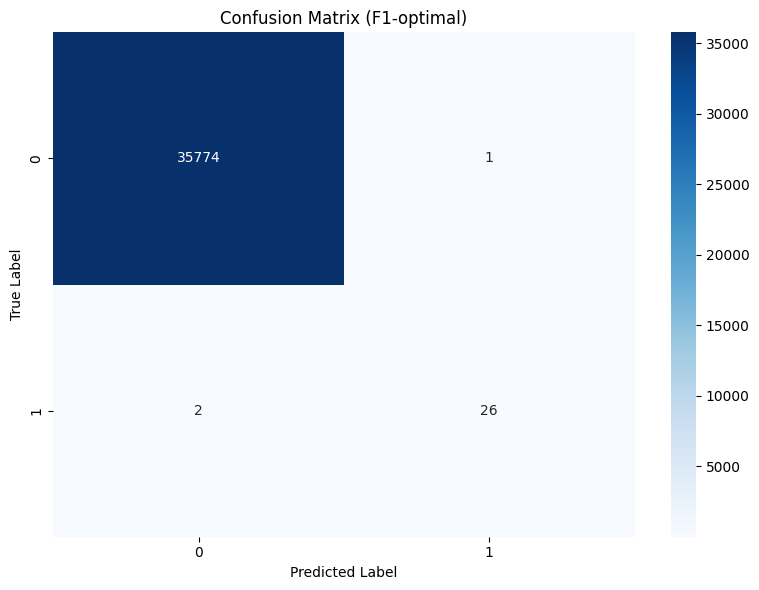

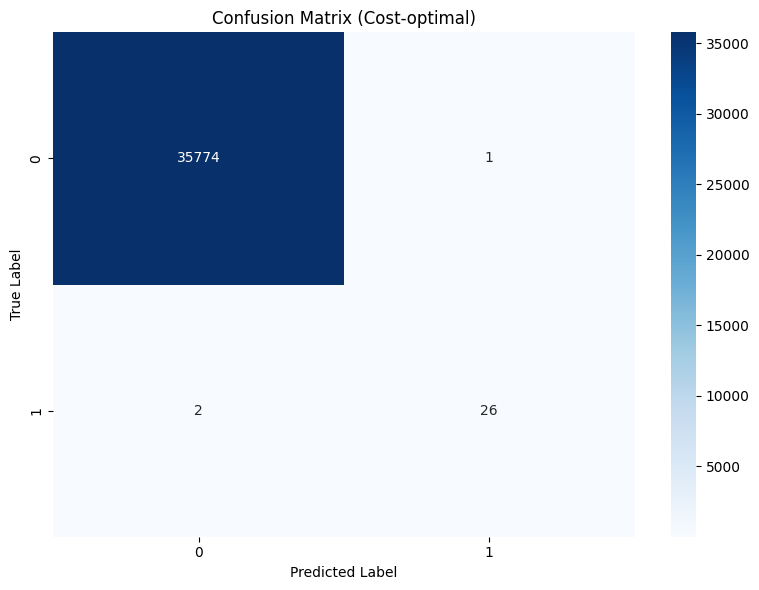

In [20]:
# 14. Final Model Evaluation
print("\n--- Final Model Evaluation ---")

# Create evaluation results for both thresholds
for threshold_name, threshold_value in [("F1-optimal", f1_threshold),
                                       ("Cost-optimal", cost_threshold)]:
    print(f"\nEvaluation with {threshold_name} threshold ({threshold_value:.4f}):")
    y_pred = (y_pred_proba >= threshold_value).astype(int)

    # Calculate metrics
    # Ensure y_test is of integer type
    report = classification_report(y_test.astype(int), y_pred, output_dict=True)
    print(classification_report(y_test.astype(int), y_pred)) # Print report with y_test as int

    # Confusion matrix (no change needed here)
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({threshold_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/confusion_matrix_{threshold_name.lower().replace("-", "_")}.png')

    # Save metrics
    # Access metrics using string keys '0' and '1'
    metrics_dict = {
        'threshold_name': threshold_name,
        'threshold_value': float(threshold_value),
        'classification_report': report,
        'confusion_matrix': cm.tolist(),
        'precision': report['1']['precision'], # Access with string key
        'recall': report['1']['recall'], # Access with string key
        'f1_score': report['1']['f1-score'], # Access with string key
        'support': report['1']['support'] # Access with string key
    }

    with open(f'{output_dir}/model_metrics_{threshold_name.lower().replace("-", "_")}.json', 'w') as f:
        json.dump(metrics_dict, f)

Precision accuracy and recall improved drastically.


--- Generating ROC and PR Curves ---


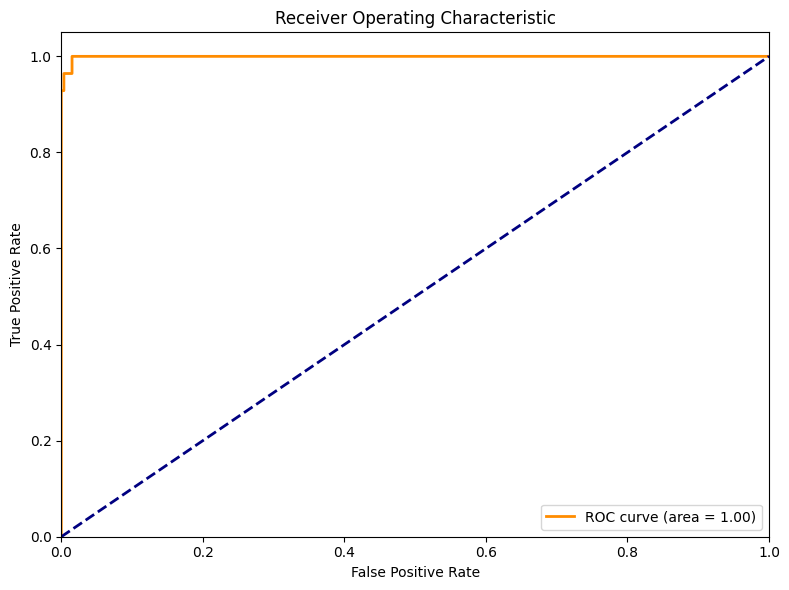

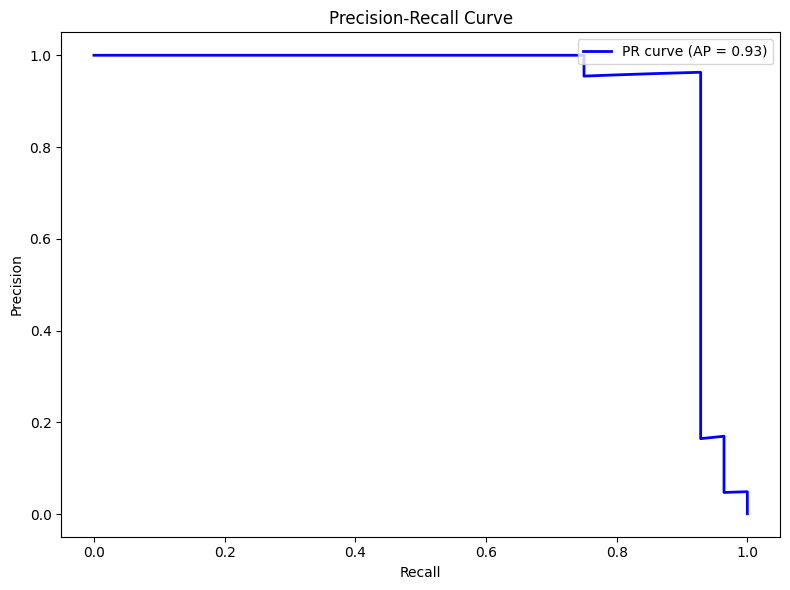

In [21]:
# 15. ROC and PR Curves
print("\n--- Generating ROC and PR Curves ---")

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f'{output_dir}/roc_curve.png')

# PR Curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f'{output_dir}/precision_recall_curve.png')


In [ ]:
# 16. Save curves data for Power BI
# ROC curve data
'''
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr
})
roc_df.to_csv(f'{output_dir}/roc_curve_data.csv', index=False)

# PR curve data
pr_df = pd.DataFrame({
    'precision': precision,
    'recall': recall
})
pr_df.to_csv(f'{output_dir}/pr_curve_data.csv', index=False)

# Threshold analysis for Power BI
threshold_df.to_csv(f'{output_dir}/threshold_analysis.csv', index=False)
'''


--- Generating Model Explanation ---
Model and preprocessor saved to fraud_detection_outputs/enhanced_fraud_detection_model.pkl


<Figure size 1200x1000 with 0 Axes>

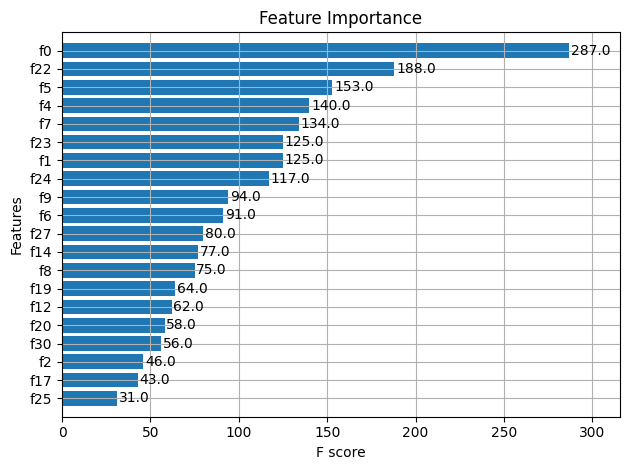

In [22]:
# 17. Create Model Explanation
print("\n--- Generating Model Explanation ---")

# Create feature importance visualization
plt.figure(figsize=(12, 10))
xgb.plot_importance(best_model, max_num_features=20, height=0.8)
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance_final.png')

# Get feature importance values
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)
importance_df.to_csv(f'{output_dir}/feature_importance_final.csv', index=False)

# 18. Save model and preprocessor
import pickle
model_path = f'{output_dir}/enhanced_fraud_detection_model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump({
        'preprocessor': preprocessor,
        'model': best_model,
        'f1_threshold': f1_threshold,
        'cost_threshold': cost_threshold,
        'feature_names': feature_names
    }, model_file)

print(f"Model and preprocessor saved to {model_path}")

In [23]:
# 18. Save model and preprocessor
import pickle
model_path = f'{output_dir}/enhanced_fraud_detection_model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump({
        'preprocessor': preprocessor,
        'model': best_model,
        'f1_threshold': f1_threshold,
        'cost_threshold': cost_threshold,
        'feature_names': feature_names
    }, model_file)

print(f"Model and preprocessor saved to {model_path}")

Model and preprocessor saved to fraud_detection_outputs/enhanced_fraud_detection_model.pkl


In [ ]:
'''
# 19. Create sample predictions for dashboard
print("\n--- Creating Sample Predictions for Dashboard ---")

# Apply both thresholds for comparison
y_pred_f1 = (y_pred_proba >= f1_threshold).astype(int)
y_pred_cost = (y_pred_proba >= cost_threshold).astype(int)

# Create results DataFrame
results_df = X_test.copy()
results_df['actual_fraud'] = y_test.values
results_df['fraud_probability'] = y_pred_proba
results_df['predicted_fraud_f1_threshold'] = y_pred_f1
results_df['predicted_fraud_cost_threshold'] = y_pred_cost

# Add original key columns
results_df = pd.concat([
    df.loc[results_df.index, ['step', 'type', 'amount', 'nameOrig', 'nameDest']],
    results_df
], axis=1)

# Save full results
results_df.to_csv(f'{output_dir}/full_prediction_results.csv', index=False)

# Create a random sample of 1000 records for dashboard
sample_size = min(1000, len(results_df))
sample_df = results_df.sample(sample_size, random_state=42)
sample_df.to_csv(f'{output_dir}/dashboard_sample.csv', index=False)


In [24]:
# 20. Transaction Analysis
print("\n--- Creating Transaction Analysis for Dashboard ---")

# Group by transaction type and day
transaction_analysis = df.groupby(['type', df['step'] // 24]).agg({
    'amount': ['count', 'sum', 'mean'],
    'isFraud': ['sum', 'mean']
}).reset_index()

transaction_analysis.columns = ['transaction_type', 'day', 'transaction_count',
                               'total_amount', 'avg_amount', 'fraud_count', 'fraud_rate']
transaction_analysis.to_csv(f'{output_dir}/transaction_analysis.csv', index=False)



--- Creating Transaction Analysis for Dashboard ---


In [25]:
# 21. Fraud Pattern Analysis
print("\n--- Creating Fraud Pattern Analysis ---")

# Find patterns in fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

# Time patterns
fraud_by_hour = fraud_df.groupby('hourOfDay').size().reset_index(name='fraud_count')
fraud_by_hour.to_csv(f'{output_dir}/fraud_by_hour.csv', index=False)

# Transaction type patterns
fraud_by_type = fraud_df.groupby('type').size().reset_index(name='fraud_count')
fraud_by_type.to_csv(f'{output_dir}/fraud_by_type.csv', index=False)

# Amount patterns
fraud_amounts = fraud_df['amount'].describe().reset_index().rename(columns={'index': 'stat'})
fraud_amounts.to_csv(f'{output_dir}/fraud_amount_stats.csv', index=False)

print("\nEnhanced fraud detection model complete!")
print(f"All outputs saved to {output_dir} directory")


--- Creating Fraud Pattern Analysis ---

Enhanced fraud detection model complete!
All outputs saved to fraud_detection_outputs directory
